In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import argparse
import locale
import math
import imutils

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model

In [3]:
def show_image(img):
    plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()

## Load dataset

In [4]:
def to_vec(df):
    image_paths = []
    labels = []
    for i, row in df.iterrows():
        image_paths.append(row['image_path'])
        labels.append([row["rx"],row["ry"],row["rz"]])
#         data.append([row['image_path'],row["rx"]])
#     print([image_paths, labels])
#     df = pd.DataFrame(list(zip([image_paths, labels])), columns = ['image_path', "label"]) 

    return [image_paths, labels]

In [5]:
dataset = pd.read_csv("/mnt/notebooks/Project - Pose/PoseNet/train/t3/training_set.pkl", index_col=0)

In [6]:
dataset

,image_path,rx,ry,rz,tx,ty,tz
0,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.149999,0.032741,-0.004810,-97.379855,-76.632717,5796.087256
1,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.151979,0.028118,-0.083070,-83.581238,-64.393175,5062.087588
2,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.150890,0.029580,-0.057791,-78.612181,-58.901688,4733.616233
3,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.160499,0.010928,-0.371373,-91.505845,-79.022972,5876.522082
4,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.151126,0.031624,-0.024558,-111.413824,-91.055609,6661.815756
...,...,...,...,...,...,...,...
149995,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.101973,-0.037596,-0.003047,-117.960056,-95.364951,7066.409430
149996,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.102070,-0.035291,0.063563,-119.302908,-95.279037,7057.523388
149997,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.099335,-0.034353,0.094532,-78.039788,-53.348556,4540.251013
149998,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.099386,-0.046591,-0.276257,-86.400386,-70.625525,5536.354176


In [7]:
dataset = dataset.dropna()

In [8]:
pd_dataset = to_vec(dataset)

In [9]:
image_paths, lables = pd_dataset[0],pd_dataset[1]

In [10]:
np.array(lables).shape

(147345, 3)

In [11]:
def load_images(paths):
    images = []
    for path in paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if np.array(image).sum() == 1:
            print(path)
        new_image = tf.keras.applications.vgg16.preprocess_input(image)

        images.append(new_image)
        
    return np.array(images)

In [55]:
images = load_images(image_paths)

In [12]:
split = train_test_split(images, lables, test_size=0.25, random_state=42)
(trainImagesX,testImagesX, trainY, testY ) = split

NameError: name 'images' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


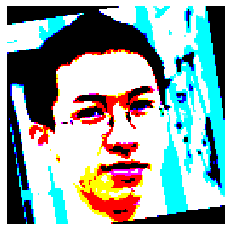

[0.1899917353079344, -0.1866770056159824, -0.2209003246741079]


In [57]:
selected_img = 30
show_image(testImagesX[selected_img])
print(testY[selected_img])

In [12]:
def compile_inceptionV3(lr=0.001):
    model_vgg = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128,128,3))
    x = model_vgg.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.20)(x)
    predictions = tf.keras.layers.Dense(3, activation="linear")(x)
    model_vgg = tf.keras.Model(inputs=model_vgg.input, outputs=predictions)

    model_vgg.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=lr))
    
    print(model_vgg.summary())
    return model_vgg

def compile_vgg16(lr=0.001, non_trainable_layers=15):
    model_vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128,128,3))
    x = model_vgg.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.20)(x)
    predictions = tf.keras.layers.Dense(3, activation="linear")(x)
    model_vgg = tf.keras.Model(inputs=model_vgg.input, outputs=predictions)


#     self.model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    for i, layer in enumerate(model_vgg.layers):
        if i < non_trainable_layers:
            layer.trainable = False
        else:
            layer.trainable = True

    model_vgg.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=lr))
    
    print(model_vgg.summary())
    return model_vgg

In [13]:
def train_model(model, train_x, test_x, train_y, test_y, epochs, batch_size=32):
    model.fit(train_x, np.array(train_y), batch_size=32, epochs=epochs, verbose=1,shuffle=True)
    print(evaluate(model, test_x, test_y))
    

def train_model_generator(model, train_gen,test_gen, test_y, epochs):
    model.fit_generator(train_gen,epochs=epochs)
    preds = model.predict_generator(test_gen)
    print(calc_mse(test_y, preds))

1. clean data from empty files
2. try train model
3. train vgg if no result try inception
4. my net


In [58]:
model_in = compile_inceptionV3(lr=0.00001)
train_model(model_in,trainImagesX, testImagesX, trainY, testY, epochs=8)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_282 (Bat (None, 63, 63, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 63, 63, 32)   0           batch_normalization_v1_282[0][0] 
__________________________________________________________________________________________________
conv2d_283

Epoch 1/8
22500/22500 [==============================] - 88s 4ms/sample - loss: 0.1648
Epoch 2/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0955
Epoch 3/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0882
Epoch 4/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0840
Epoch 5/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0800
Epoch 6/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0745
Epoch 7/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0673
Epoch 8/8
22500/22500 [==============================] - 71s 3ms/sample - loss: 0.0578


NameError: name 'evaluate' is not defined

In [62]:
evaluate(model_in, testImagesX, testY)

[INFO] predicting pose...
[[ 0.14169171 -0.12929592  0.2143935 ]
 [ 0.06465065 -0.4122302  -0.05818623]
 [ 0.09262966 -0.11019565 -0.17861123]
 [ 0.27972314  0.21328361  0.02870385]
 [ 0.19874167  0.03613139 -0.3357223 ]]
The Mean Square Error is:  0.0787865334212437


In [63]:
model_vgg_220_1 = compile_vgg16(lr=0.00001)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [502]:
# dripout 0.2
model_vgg_220_2 = compile_vgg16()
train_model(model_vgg_220_2,trainImagesX, testImagesX, trainY, testY, epochs=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

### Trying to see improve with epochs
if i do i will run random search tmw but first i'll evaluate the models againinset the evaluation set


Trying different model alexnet
a simpler model
a bigger dataset
different learning rate

In [501]:
evaluate(model_vgg_220, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.09758186905147864


In [500]:
evaluate(model_vgg_220_1, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.0974718806457217


In [499]:
evaluate(model_vgg_220_2, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.09773930470079295


In [18]:
def calc_mse(y, y_pred):
    mse = ((y - y_pred)**2).mean(axis=None)
# #     summation = 0  #variable to store the summation of differences
#     n = len(y) #finding total number of items in list
#     for i in range (0,n):  #looping through each element of the list
#         difference = abs((y[i] - y_pred[i]).sum())  #finding the difference between observed and predicted value
#         squared_difference = np.sqrt(difference)  #taking square of the differene 
#         if(not math.isnan(squared_difference)):
#             summation = summation + squared_difference  #taking a sum of all the differences
#     MSE = summation/n  #dividing summation by total values to obtain average
    print( "The Mean Square Error is: " , mse)

In [61]:
# 1 batches
calc_mse(testY, p)

TypeError: unsupported operand type(s) for -: 'list' and 'str'

In [438]:
# 2 batches
calc_mse(testY, p)

The Mean Square Error is:  0.46358638723507856


In [445]:
# 20 batches
calc_mse(testY, p)

The Mean Square Error is:  0.4491790638609906


In [448]:
# 20 batches
calc_mse(testY, p)

The Mean Square Error is:  0.4491790638609906


In [146]:
model_vgg_220_1 = compile_vgg16(lr=0.00001)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [147]:
model_vgg_220_1.predict(testImagesX[3:6])

array([[ 0.20011054, -0.06067495,  0.05777963],
       [ 0.08028145, -0.03982532, -0.11417163],
       [ 0.14486001, -0.01537884, -0.03081495]], dtype=float32)

In [149]:
model_vgg_220_1.predict(np.zeros((128,128,3)).reshape((1,128,128,3)))

array([[ 0.1765491, -0.3315804, -0.537317 ]], dtype=float32)

In [150]:
model_vgg_220_1.predict(np.ones((128,128,3)).reshape((1,128,128,3))*255)

array([[0.00262151, 2.107149  , 0.2367273 ]], dtype=float32)

## tring fit_generator

In [14]:
def create_generator(dataset, shuffle, image_size, class_mode="raw", y_col=["rx","ry","rz"], workers=0, use_multiprocessing=False):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
         preprocessing_function=tf.keras.applications.vgg16.preprocess_input
#          preprocessing_function=
    )

    generator = data_gen.flow_from_dataframe(
        dataframe=dataset,
        x_col="image_path",
        y_col=y_col,
        target_size=image_size,
        color_mode="rgb",
        batch_size=32,
        class_mode=class_mode,
        shuffle=shuffle,
        workers=workers,
        use_multiprocessing=use_multiprocessing,

    )
    return generator


In [15]:
ds_train, ds_test = train_test_split(dataset,test_size=0.25, random_state=42)
split = train_test_split(image_paths,  lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [16]:
train_gen = create_generator(ds_train, True, (128,128), workers=32, use_multiprocessing=True)
test_gen = create_generator(ds_test, False,(128,128))
test_gen_sample = create_generator(ds_test[:5], False,(128,128), class_mode=None)

Found 110508 validated image filenames.
Found 36837 validated image filenames.
Found 5 validated image filenames.


In [16]:
pd_set = pd.DataFrame(list(zip(image_paths,  lables)), columns=["image_path","label"])

In [17]:
ds_train, ds_test = train_test_split(pd_set,test_size=0.25, random_state=42)
split = train_test_split(image_paths,  lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [120]:
train_gen = create_generator(ds_train, True, (128,128),workers=32,use_multiprocessing=True,y_col=["label"])
test_gen = create_generator(ds_test, False,(128,128),y_col=["label"])
test_gen_sample = create_generator(ds_test[:5], False,(128,128), class_mode=None,y_col=["label"])

Found 110508 validated image filenames.
Found 36837 validated image filenames.
Found 5 validated image filenames.


Trying empty images
trying yo train only one epoch

In [18]:
show_image(images[7])

NameError: name 'images' is not defined

In [24]:
model_inception = compile_inceptionV3()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_282 (Bat (None, 63, 63, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 63, 63, 32)   0           batch_normalization_v1_282[0][0] 
__________________________________________________________________________________________________
conv2d_283

In [25]:
model_inception.predict_generator(test_gen_sample)

array([[-15.905819 , -27.003265 ,  -4.7278366],
       [ -3.200807 ,  -3.436205 , -11.192465 ],
       [-40.188435 , -16.53334  , -13.37679  ],
       [-16.248056 ,   9.569971 , -16.70403  ],
       [-10.487112 , -12.121643 , -10.497492 ]], dtype=float32)

Trying to understand if the problams i have has something to do with the size of the dataset

In [ ]:
# model_inception.fit_generator(
#         train_gen,
#         epochs=8)
# #         validation_data=test_ge n)
train_model_generator(model_inception, train_gen, test_gen, testY, epochs=8)

Epoch 1/8
3454/3454 [==============================] - 440s 127ms/step - loss: 0.1300
Epoch 2/8
2992/3454 [========================>.....] - ETA: 49s - loss: 0.0780

In [ ]:
preds = model_inception.predict_generator(test_gen)


In [39]:
calc_mse(testY, preds)

The Mean Square Error is:  1090.057156797663


In [41]:
preds[0]

array([0.02850209, 0.07719573, 0.14789163], dtype=float32)

In [42]:
testY[0]

[-0.04613893599204024, 0.08359794502373916, 0.10921778020419774]

In [40]:
from imutils import face_utils


ModuleNotFoundError: No module named 'imutils'

In [26]:
model_inception.predict_generator(test_gen_sample)

NameError: name 'test_gen_sample' is not defined

In [88]:
preds = model_inception.predict_generator(test_gen)

In [89]:
preds.mean()

0.06324926

In [90]:
preds.max()

0.5609654

In [91]:
preds.min()

-0.5118396

In [ ]:
calc_mse()

In [159]:
model_vgg.predict(np.zeros((128,128,3)).reshape((1,128,128,3)))

array([[ 0.4614623 , -0.15461743, -0.07017204]], dtype=float32)

In [160]:
model_vgg.predict(np.ones((128,128,3)).reshape((1,128,128,3))*255)

array([[ 0.14443067, -0.01239607, -0.05454065]], dtype=float32)

In [19]:
model_vgg1 = compile_vgg16(non_trainable_layers=19)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 1

In [31]:
model_vgg1.predict_generator(test_gen_sample)

array([[-4.182028  ,  4.7351847 ,  0.01844859],
       [-0.58347464,  7.5438    ,  3.268713  ],
       [-1.6847295 ,  5.7104664 , -2.9832647 ],
       [-2.9661727 ,  1.0211923 , -0.21186596],
       [-3.819543  ,  3.394865  ,  0.9197124 ]], dtype=float32)

Trying to understand if the problams i have has something to do with the size of the dataset

In [32]:
# model_inception.fit_generator(
#         train_gen,
#         epochs=8)
# #         validation_data=test_ge n)
train_model_generator(model_vgg1, train_gen, test_gen, testY, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3454/3454 [==============================] - 2344s 679ms/step - loss: 0.5118
Epoch 2/20
3454/3454 [==============================] - 120s 35ms/step - loss: 0.0895
Epoch 3/20
3454/3454 [==============================] - 117s 34ms/step - loss: 0.0888
Epoch 4/20
3454/3454 [==============================] - 118s 34ms/step - loss: 0.0882
Epoch 5/20
3454/3454 [==============================] - 118s 34ms/step - loss: 0.0879
Epoch 6/20
3454/3454 [==============================] - 119s 34ms/step - loss: 0.0878
Epoch 7/20
3454/3454 [==============================] - 120s 35ms/step - loss: 0.0877
Epoch 8/20
3454/3454 [==============================] - 119s 35ms/step - loss: 0.0875
Epoch 9/20
3454/3454 [==============================] - 120s 35ms/step - loss: 0.0874
Epoch 10/20
3454/3454 [==============================] - 120s 35ms/step - loss: 0.0875
Epoch 11/20
3454/3454 [==============================] - 120s 35ms/step - loss: 0.0874
Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3454/3454 [==============================] - 116s 34ms/step - loss: 0.0873
Epoch 19/20
3454/3454 [==============================] - 119s 34ms/step - loss: 0.0872
Epoch 20/20
1429/3454 [===========>..................] - ETA: 1:08 - loss: 0.0872

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3454/3454 [==============================] - 117s 34ms/step - loss: 0.0873
The Mean Square Error is:  0.08613176468217025
None


In [33]:
model_vgg1.predict_generator(test_gen_sample)

array([[ 0.0647407 ,  0.0176084 , -0.04312471],
       [ 0.10138202,  0.06154134, -0.03140149],
       [ 0.22565973,  0.02308767, -0.09800967],
       [ 0.12548651,  0.00526439, -0.01530899],
       [ 0.15903583, -0.18284419,  0.11102314]], dtype=float32)

In [298]:
weights, biases = model_vgg.layers[2].get_weights()


In [299]:
weights

array([[[[ 1.66219279e-01,  1.42701820e-01, -4.02113283e-03, ...,
           6.18828237e-02, -1.74057148e-02, -3.00644431e-02],
         [ 9.46945231e-03,  3.87477316e-03,  5.08365929e-02, ...,
          -2.77981739e-02,  1.71373668e-03,  6.82722731e-03],
         [ 6.32681847e-02,  2.12877709e-02, -1.63465310e-02, ...,
           8.80054955e-04,  6.68104272e-03, -1.41139806e-03],
         ...,
         [ 3.47490981e-03,  8.47019628e-02, -4.07223180e-02, ...,
          -1.13523193e-02, -7.48998486e-03,  3.19077494e-03],
         [ 5.97234145e-02,  4.97663505e-02, -3.23118735e-03, ...,
           1.43114366e-02,  3.03175431e-02, -4.23925705e-02],
         [ 1.33459672e-01,  4.95484173e-02, -1.78808011e-02, ...,
           2.25385167e-02,  3.02020740e-02, -2.17075031e-02]],

        [[ 2.12007999e-01,  2.10127644e-02, -1.47626130e-02, ...,
           2.29580477e-02,  1.23102348e-02, -3.08422819e-02],
         [-2.62175221e-03,  7.42094172e-03,  6.74030930e-02, ...,
          -3.06594316e

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)

In [142]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
# diff = preds.flatten() - testY
# percentDiff = (diff / testY) * 100
# absPercentDiff = np.abs(percentDiff)

In [17]:
def evaluate(model, testImagesX, testY):
    # make predictions on the testing data
    print("[INFO] predicting pose...")
    preds = model.predict(testImagesX)
    print(model.predict(testImagesX[:5]))
    # # compute the mean and standard deviation of the absolute percentage
    # # difference
    # mean = np.mean(absPercentDiff)
    # std = np.std(absPercentDiff)

    # # finally, show some statistics on our model
    # locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    # # print("[INFO] avg. house price: {}, std house price: {}".format(
    # # locale.currency(df["price"].mean(), grouping=True),
    # # locale.currency(df["price"].std(), grouping=True)))
    # print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
    calc_mse(testY, preds)

## Custom generator

In [27]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128,128), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            image = cv2.imread(self.list_IDs[ID])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X[i,] = image

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [28]:
split = train_test_split(image_paths, lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [218]:
# Parameters
params = {'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator(trainImagesPathsX, trainY, **{'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True})
validation_generator = DataGenerator(testImagesPathsX, testY, **{'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': False})


In [263]:
model = create_cnn(128,128,3, regress=True)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
__________

In [15]:
model = compile_vgg16()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_______________________________________

In [18]:
model.predict(testImagesX[3:10])

NameError: name 'testImagesX' is not defined

In [ ]:
model.fit_generator(
        train_gen2,
         steps_per_epoch=960,
    
        epochs=30)
#         validation_data=test_ge n)

Epoch 1/30
960/960 [==============================] - 26s 27ms/step - loss: 0.1769
Epoch 2/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0887
Epoch 3/30
250/960 [======>.......................] - ETA: 16s - loss: 0.0928

In [ ]:
model.predict(testImagesX[3:10])

In [29]:
split = train_test_split(image_paths, lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [30]:
labels_dict = {}
for p, l in zip(image_paths, lables):
    labels_dict[p] = l

In [31]:
def preprocess_input(image):
    return image

# from skimage.io import imread
def get_input(path):
    
#     img = imread(path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    return(image)


def get_output(path,label_file=None):
    
#     img_id = path.split('/')[-1].split('.')[0]
#     img_id = np.int64(img_id)
#     labels = label_file.loc[img_id].values
    return label_file[path]
    
    return(labels)
def image_generator(files, labels, batch_size = 64):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, 
                                     size = batch_size)
        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            input = get_input(input_path )
            output = get_output(input_path, label_file=labels )

            input = preprocess_input(image=input)
            batch_input += [ input ]
            batch_output += [ output ]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )

        yield( batch_x, batch_y )

In [32]:
train_gen2 = image_generator(trainImagesPathsX, labels_dict, 32)

In [43]:
labels_dict

{'/mnt/notebooks/Project - Pose/PoseNet/train/t3//0_79440.png': [0.14999936945441952,
  0.032740588148246395,
  -0.0048103493182826435],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//1_72586.png': [0.151979069056793,
  0.02811789286667126,
  -0.08306955160490058],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//2_18518.png': [0.15089002850611058,
  0.02957953782954328,
  -0.057791428635368215],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//3_13684.png': [0.1604987652584763,
  0.010927609327337705,
  -0.3713728309649624],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//4_29089.png': [0.15112592514586734,
  0.03162443015212351,
  -0.02455792242898441],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//0_46041.png': [0.046289636569720884,
  -0.08781189812245127,
  -0.10969427704103073],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//1_22416.png': [0.04322691346031611,
  -0.08808601001840306,
  -0.1858484228860965],
 '/mnt/notebooks/Project - Pose/PoseNet/train/t3//2_81044.p